In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as stats
import random

In [2]:
sample = np.loadtxt("hw7-cluster5-data1000.dat.txt", unpack = True)

In [3]:
# (a) Implement the K-logK Initialization algorithm as a generic function.
# K logK initialization 
def K_logK_Initialization(data, K, c):
    ### calculate the value of K' which equals K′ = c*K*lnK
    num_init_centers = int(K*c*np.log(K))
    
    ### Run 1 step of K-means
    # Assign each initial center a random points in data
    mu_0_k_x = random.sample(list(data[0]), num_init_centers) # randomly assign x-values of K' points to initial centers(mu_0_k_x)
    mu_0_k_y = []                                               # for-loop: get the corresponding y-values of these points
    for i in mu_0_k_x:
        mu_0_k_y.append(data[1][list(data[0]).index(i)])    
    
    # Assign points to clusters
    k_xi = []                                                   # create an array store which cluster the data belongs to
    for i in range(len(data[0])):                               # for-loop: for each data points
        k_s = []    # k_s: stores the distances that one point to each center
        for ki in range(len(mu_0_k_x)):                         # for-loop: calculate and store distances that one data to each centers
            distance = np.sqrt((data[0][i]-mu_0_k_x[ki])**2 + (data[1][i]-mu_0_k_y[ki])**2)
            k_s.append(distance)
        k_min = k_s.index(min(k_s))+1                           # find the cluster center that the data is closest to
        k_xi.append(k_min)                                      # add to the k_xi
    
    # recalculate centers
    mu_new_k_x = [0] * len(mu_0_k_x)                            # create an array to store the new x-values of cluster centers
    mu_new_k_y = [0] * len(mu_0_k_y)                            # create an array to store the new y-values of cluster centers
    for i in range(len(k_xi)):                                  # for-loop: for each data point 
        for j in range(1, len(mu_0_k_x)+1):                     # for-loop: for each cluster center
            if k_xi[i] == j:                                    # if the data point's cluster = cluster center
                mu_new_k_x[j-1] = mu_new_k_x[j-1] + data[0][i]  # accumulate the corresponding cluster center's x-values
                mu_new_k_y[j-1] = mu_new_k_y[j-1] + data[1][i]  # accumulate the corresponding cluster center's y-values
    for i in range(len(mu_new_k_x)):                            # for-loop: for each cluster center
        mu_new_k_x[i] = mu_new_k_x[i]/k_xi.count(i+1)           # average the sum of x-values to get new x-value
        mu_new_k_y[i] = mu_new_k_y[i]/k_xi.count(i+1)           # average the sum of y-values to get new y-value
    
    
    ### Remove all centers that have few data points:
    mu_remain_k_x = []
    mu_remain_k_y = []
    threshold = len(data[0])/(np.e * num_init_centers)
    for i in range(len(mu_new_k_x)):
        count = k_xi.count(i+1)
        if count >= threshold:
            mu_remain_k_x.append(mu_new_k_x[i])
            mu_remain_k_y.append(mu_new_k_y[i])
    
    ### From the remaining centers select K centers by Furthest First Traversal
    mu_final_x = []
    mu_final_y = []
    temp = random.choice(mu_remain_k_x)
    mu_final_x.append(temp)
    mu_final_y.append(mu_remain_k_y[mu_remain_k_x.index(temp)])
    mu_remain_k_x.remove(mu_final_x[0])
    mu_remain_k_y.remove(mu_final_y[0])
    for k in range(K-1):
        dists = []
        for i in range(len(mu_remain_k_x)):
            for j in range(len(mu_final_x)):
                temp_dists = []
                temp_dists.append(np.sqrt((mu_remain_k_x[i]-mu_final_x[j])**2 + (mu_remain_k_y[i]-mu_final_y[j])**2))
            dists.append(min(temp_dists))
        furthest = max(dists)
        ind = dists.index(furthest)
        mu_final_x.append(mu_remain_k_x.pop(ind))
        mu_final_y.append(mu_remain_k_y.pop(ind))
    
    result = []
    result.append(mu_final_x)
    result.append(mu_final_y)
    return result

# Naive Initialization
def NiInitialization(data, K):
    mu_x = random.sample(list(data[0]), 4)
    mu_y = []
    for i in mu_x:
        mu_y.append(data[1][list(data[0]).index(i)])    
    result = []
    result.append(mu_x)
    result.append(mu_y)
    
    return result

# calculate the cost
def cost(centers, data, k_xi):
    result = 0
    for i in range(len(k_xi)):
        for j in range(len(centers[0])):
            if k_xi[i] == j+1:
                result += (data[0][i] - centers[0][j])**2 + (data[1][i] - centers[1][j])**2
    return result


### Implement the K-means algorithm proper.
# K_means
def K_means(data, centers, K, T):
    
    result = {
        "centers": [centers],
        "cost": []
    }    
    
    for z in range(T):
        
        k_xi_o = []                                                   # create an array store which cluster the data belongs to
        for i in range(len(data[0])):                               # for-loop: for each data points
            k_s = []    # k_s: stores the distances that one point to each center
            for ki in range(len(result.get("centers")[z][0])):                         # for-loop: calculate and store distances that one data to each centers
                distance = np.sqrt((data[0][i]-result.get("centers")[z][0][ki])**2 
                                   + (data[1][i]-result.get("centers")[z][1][ki])**2)
                k_s.append(distance)
            k_min = k_s.index(min(k_s))+1                           # find the cluster center that the data is closest to
            k_xi_o.append(k_min)
        
        # recalculate centers
        new_centers = [[]] * 2
        new_centers[0] = [0] * len(centers[0])                            # create an array to store the new x-values of cluster centers
        new_centers[1] = [0] * len(centers[1])                            # create an array to store the new y-values of cluster centers
        for i in range(len(k_xi_o)):                                  # for-loop: for each data point 
            for j in range(1, len(centers[0])+1):                     # for-loop: for each cluster center
                if k_xi_o[i] == j:                                    # if the data point's cluster = cluster center
                    new_centers[0][j-1] = new_centers[0][j-1] + data[0][i]  # accumulate the corresponding cluster center's x-values
                    new_centers[1][j-1] = new_centers[1][j-1] + data[1][i]  # accumulate the corresponding cluster center's y-values
        for i in range(len(new_centers[0])):                            # for-loop: for each cluster center
            new_centers[0][i] = new_centers[0][i]/k_xi_o.count(i+1)           # average the sum of x-values to get new x-value
            new_centers[1][i] = new_centers[1][i]/k_xi_o.count(i+1)           # average the sum of y-values to get new y-value
        
        result.get("centers").append(new_centers)  

        
        k_xi = []                                                   # create an array store which cluster the data belongs to
        for i in range(len(data[0])):                               # for-loop: for each data points
            k_s = []    # k_s: stores the distances that one point to each center
            for ki in range(len(new_centers[0])):                         # for-loop: calculate and store distances that one data to each centers
                distance = np.sqrt((data[0][i]-new_centers[0][ki])**2 
                                   + (data[1][i]-new_centers[1][ki])**2)
                k_s.append(distance)
            k_min = k_s.index(min(k_s))+1                           # find the cluster center that the data is closest to
            k_xi.append(k_min)
        
        result.get("cost").append(cost(new_centers, data, k_xi))
        
        if abs(result.get("cost")[z] - cost(result.get("centers")[z], data, k_xi_o)) < 0.0001:
            break
        
    return result
        
        
        
        

In [4]:
# run K-means with K-logK initialization
mu_0 = K_logK_Initialization(sample, 4, 2)
result = K_means(sample, mu_0, 4, 100)

number of iterations: 9


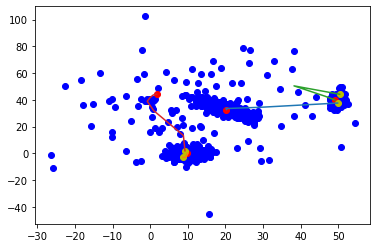

In [5]:
# plot
print("number of iterations: " + str(len(result.get("centers"))))
plt.scatter(sample[0], sample[1], color="b")
plt.scatter(result.get("centers")[len(result.get("centers"))-1][0], 
            result.get("centers")[len(result.get("centers"))-1][1], color = "r")
plt.scatter(mu_0[0], 
            mu_0[1], color = "y")
mu1_x = []
mu2_x = []
mu3_x = []
mu4_x = []
mu1_y = []
mu2_y = []
mu3_y = []
mu4_y = []
for i in range(len(result.get("centers"))):
    mu1_x.append(result.get("centers")[i][0][0])
    mu2_x.append(result.get("centers")[i][0][1])
    mu3_x.append(result.get("centers")[i][0][2])
    mu4_x.append(result.get("centers")[i][0][3])
    mu1_y.append(result.get("centers")[i][1][0])
    mu2_y.append(result.get("centers")[i][1][1])
    mu3_y.append(result.get("centers")[i][1][2])
    mu4_y.append(result.get("centers")[i][1][3])
plt.plot(mu1_x, mu1_y)
plt.plot(mu2_x, mu2_y)
plt.plot(mu3_x, mu3_y)
plt.plot(mu4_x, mu4_y)

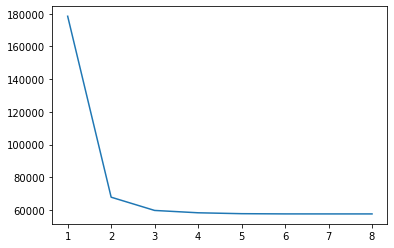

In [21]:
# plot the cost
x_l = np.array(range(1, len(result.get("cost"))+1))
y_l = result.get("cost")
plt.plot(x_l, y_l)

In [19]:
# Run K-means with Naive Initialization
mu_0_n = NiInitialization(sample, 4)
result_n = K_means(sample, mu_0_n, 4, 100)

14


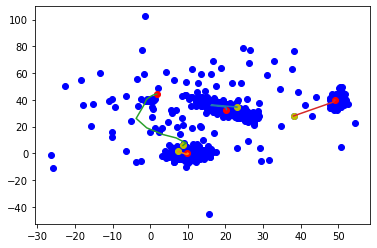

In [20]:
# plot
print(len(result_n.get("centers")))
plt.scatter(sample[0], sample[1], color="b")
plt.scatter(result_n.get("centers")[len(result_n.get("centers"))-1][0], 
            result_n.get("centers")[len(result_n.get("centers"))-1][1], color = "r")
plt.scatter(mu_0_n[0], 
            mu_0_n[1], color = "y")
mu1_x = []
mu2_x = []
mu3_x = []
mu4_x = []
mu1_y = []
mu2_y = []
mu3_y = []
mu4_y = []
for i in range(len(result_n.get("centers"))):
    mu1_x.append(result_n.get("centers")[i][0][0])
    mu2_x.append(result_n.get("centers")[i][0][1])
    mu3_x.append(result_n.get("centers")[i][0][2])
    mu4_x.append(result_n.get("centers")[i][0][3])
    mu1_y.append(result_n.get("centers")[i][1][0])
    mu2_y.append(result_n.get("centers")[i][1][1])
    mu3_y.append(result_n.get("centers")[i][1][2])
    mu4_y.append(result_n.get("centers")[i][1][3])
plt.plot(mu1_x, mu1_y)
plt.plot(mu2_x, mu2_y)
plt.plot(mu3_x, mu3_y)
plt.plot(mu4_x, mu4_y)
# 1, len(result_n.get("centers"))-1

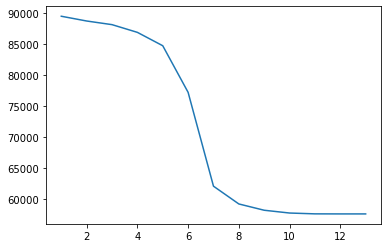

In [22]:
# Plot on a graph the cost versus the iteration t = 1 : T for the two initialization methods.
x_n = np.array(range(1, len(result_n.get("cost"))+1))
y_n = result_n.get("cost")
plt.plot(x_n, y_n)

In [3]:
np.log(np.e)

1.0